1. Load data
2. Calculate descriptors
3. Descriptor analysis
4. Apply ML methods to solubility prediction task
    - Linear Regression
    - Random Forest

In [1]:
from typing import List, Optional
from itertools import islice

import numpy as np

import pandas as pd

import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

import shap

import scipy
from scipy.stats import norm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

2023-10-17 21:07:23.125807: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 21:07:23.179971: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 21:07:23.180750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 21:07:24.427028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'

In [2]:
sns.set(style="ticks")
%matplotlib inline

In [3]:
solubility_column_name = "measured log(solubility:mol/L)"

## 1. Load Data

In [4]:
# downloaded from https://github.com/deepchem/deepchem/blob/master/datasets/delaney-processed.csv

df = pd.read_csv("./data/ci034243xsi20040112_053635.txt")

In [5]:
print(df.shape)
df.head(5)

(1144, 4)


,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [6]:
df.columns

Index(['Compound ID', 'measured log(solubility:mol/L)',
       'ESOL predicted log(solubility:mol/L)', 'SMILES'],
      dtype='object')

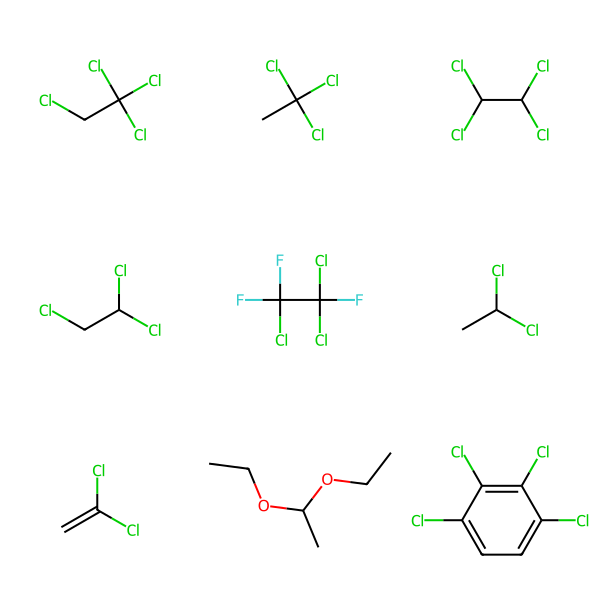

In [7]:
df_molecules = [Chem.MolFromSmiles(smile) for smile in df["SMILES"]]
Draw.MolsToGridImage(df_molecules[:9], molsPerRow=3)

In [8]:
def histogram_plot(df: pd.DataFrame, x_axis: str, x_label: str):
    plt.figure(figsize=(5, 5))

    data = df[x_axis].tolist()
    mu, sigma = norm.fit(data)

    n, bins, patches = plt.hist(data, bins=50,  density=True, alpha=0.9)

    y = norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, "k--", linewidth=2)
    print(r"mu=%.3f, sigma=%.3f" %(mu, sigma))
    plt.title(r"$\mu=%.3f,\ \sigma=%.3f$" %(mu, sigma))
    plt.xlabel(x_label, fontsize=14, fontweight="bold")
    plt.ylabel("Number of compounds", fontsize=14, fontweight="bold")
    plt.grid(True)
    plt.show()

mu=-3.058, sigma=2.096


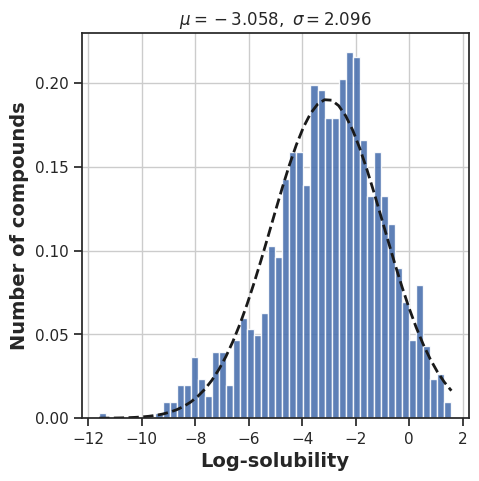

In [9]:
histogram_plot(df, "measured log(solubility:mol/L)", "Log-solubility")

## 2. Calculate Descriptors

In [10]:
def caculate_aromatic_proportion(molecule) -> float:
    aromatic_atoms = [molecule.GetAtomWithIdx(i).GetIsAromatic() for i in range(molecule.GetNumAtoms())]
    num_aromatic_atoms = sum(aromatic_atoms)
    heavy_atoms = Descriptors.HeavyAtomCount(molecule)

    return num_aromatic_atoms / heavy_atoms

In [11]:
DESCRIPTOR_FUNCTIONS = {
    "MolLogP": Descriptors.MolLogP,
    "MolWt": Descriptors.MolWt,
    "NumRotatableBonds": Descriptors.NumRotatableBonds,
    "AP": caculate_aromatic_proportion
}
DEFAULT_DESCRIPTORS = list(DESCRIPTOR_FUNCTIONS.keys())

In [12]:
def add_descriptors(df: pd.DataFrame, molecules: pd.DataFrame,
                             descriptor_names: Optional[List[str]]
                             ) -> pd.DataFrame:
    if not descriptor_names:
        descriptor_names = DEFAULT_DESCRIPTORS
    descriptors = {name: [] for name in descriptor_names}

    for molecule in molecules:
        for descriptor_name in descriptor_names:
            descriptors[descriptor_name].append(
                DESCRIPTOR_FUNCTIONS[descriptor_name](molecule))

    for descriptor_name in descriptor_names:
        df[descriptor_name] = descriptors[descriptor_name]

    return df.reset_index(drop=True)

In [13]:
df = add_descriptors(df, df_molecules, None)

In [14]:
print(df.shape)
df.head(5)

(1144, 8)


,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES,MolLogP,MolWt,NumRotatableBonds,AP
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl,2.5954,167.850,0,0.0
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl,2.3765,133.405,0,0.0
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl,2.5938,167.850,1,0.0
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl,2.0289,133.405,1,0.0
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl,2.9189,187.375,1,0.0


## 3. Descriptor Analysis

In [15]:
def scatter_plot(df: pd.DataFrame, x_axis: str, y_axis: str, x_label: str, y_label: str, 
                 hue: str):
    plt.figure(figsize=(5.5, 5.5))

    sns.scatterplot(x=x_axis, y=y_axis, data=df, hue=hue, edgecolor="black", alpha=0.7)

    plt.xlabel(x_label, fontsize=10, fontweight="bold")
    plt.ylabel(y_label, fontsize=10, fontweight="bold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.grid(True)
    plt.show()

In [16]:
def default_descriptors_histogram_plot(df: pd.DataFrame):
    fig, axs = plt.subplots(2, 2, figsize=(13, 12))

    ind = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for (i, j), descriptor in zip(ind, DEFAULT_DESCRIPTORS):
        data = df[descriptor].tolist()
        mu, sigma = norm.fit(data)

        n, bins, patches = axs[i, j].hist(data, bins=50, density=True, alpha=0.7)

        y = norm.pdf(bins, mu, sigma)
        l = axs[i, j].plot(bins, y, "k--", linewidth=2)

        axs[i, j].set_xlabel(descriptor, fontsize=10, fontweight="bold")
        axs[i, j].set_ylabel("Number of compounds", fontsize=10, fontweight="bold")
        axs[i, j].set_title(r"$\mu=%.3f,\ \sigma=%.3f$" %(mu, sigma))
        axs[i, j].grid(True)

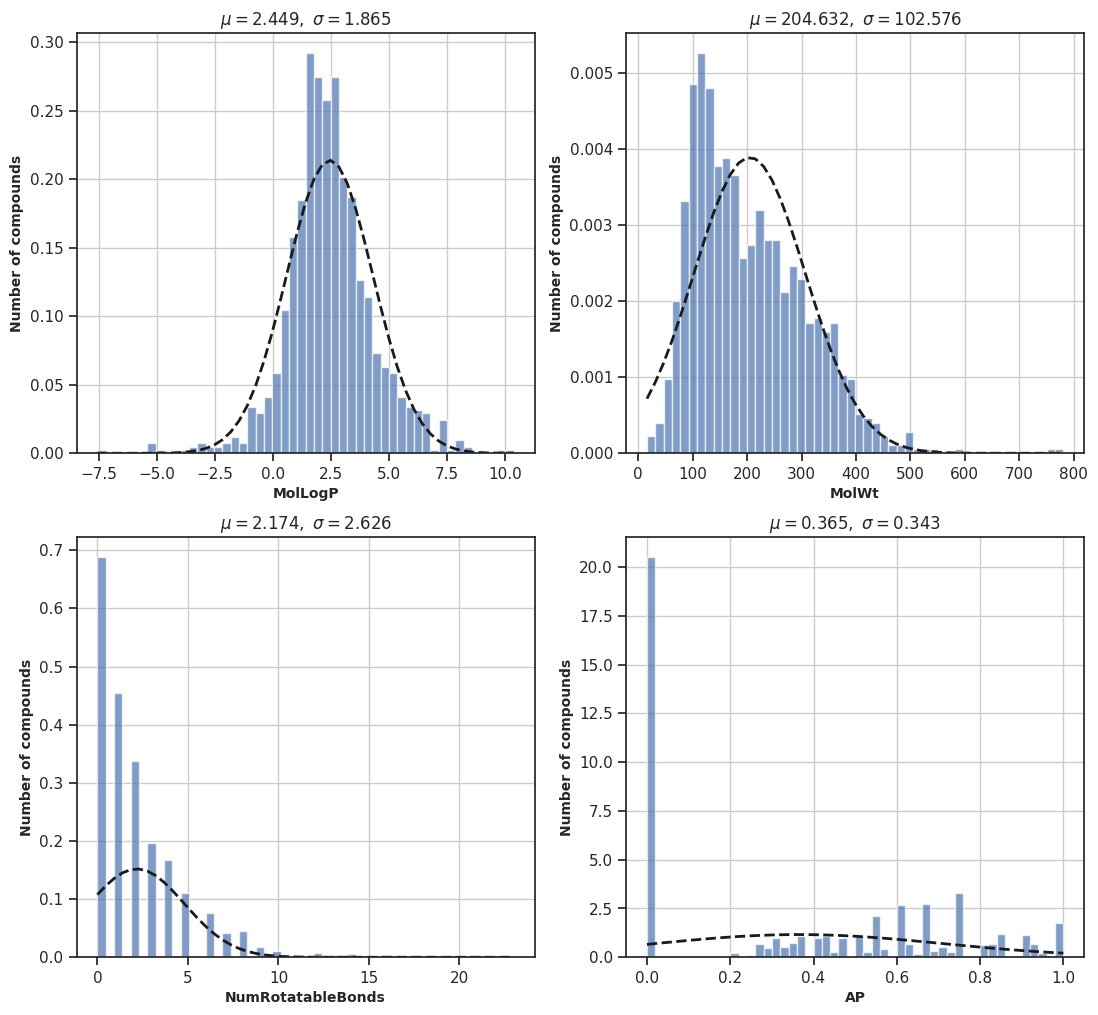

In [17]:
default_descriptors_histogram_plot(df)

<AxesSubplot: >

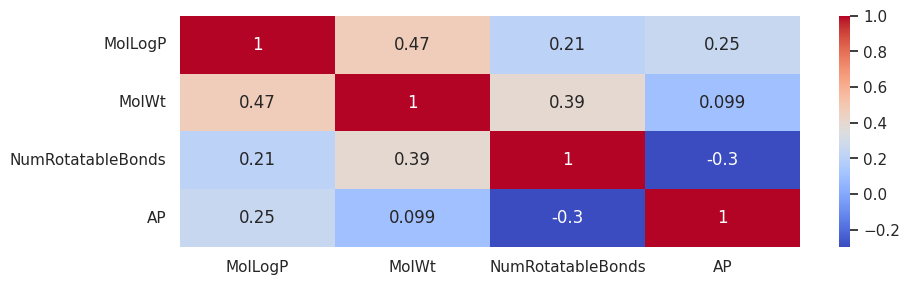

In [18]:
sns.set(rc = {"figure.figsize":(10, 3)})
sns.heatmap(df[DEFAULT_DESCRIPTORS].corr(), annot = True, fmt=".2g",cmap="coolwarm")

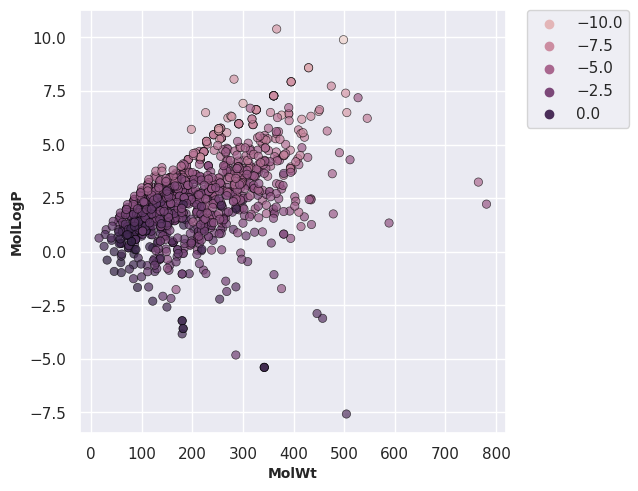

In [19]:
scatter_plot(df=df, x_axis="MolWt", y_axis="MolLogP", x_label="MolWt", y_label="MolLogP", 
                 hue=solubility_column_name)

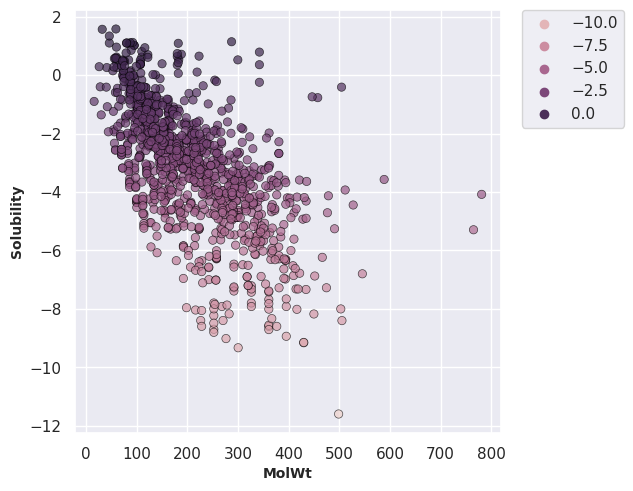

In [20]:
scatter_plot(df=df, x_axis="MolWt", y_axis=solubility_column_name, x_label="MolWt", y_label="Solubility", 
                 hue=solubility_column_name)

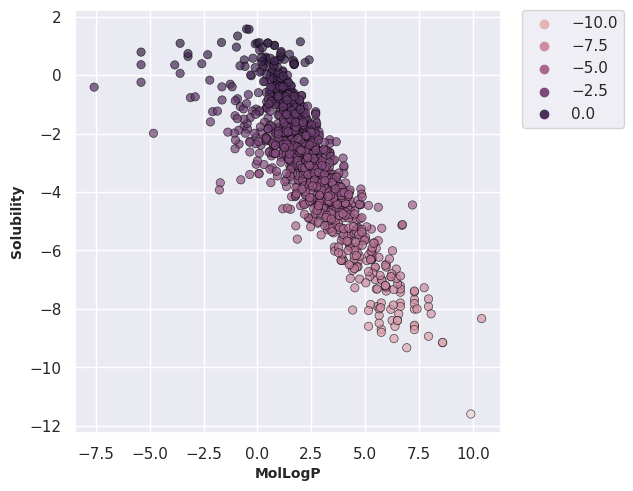

In [21]:
scatter_plot(df=df, x_axis="MolLogP", y_axis=solubility_column_name, x_label="MolLogP", y_label="Solubility", 
                 hue=solubility_column_name)

## 4. Apply ML Methods to Solubility Prediction Task

### 4.1 Dataset Preparation

In [22]:
features = DEFAULT_DESCRIPTORS

In [23]:
X = df[features].to_numpy()
y = df[solubility_column_name].to_numpy()
# y = df["ESOL predicted log(solubility:mol/L)"].to_numpy()
X.shape, y.shape

((1144, 4), (1144,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(915, 4) (915,)
(229, 4) (229,)


### 4.2 Linear Regression

In [25]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [26]:
print("Coefficients")
print("------------")
print("Intercept: %.4f" % model.intercept_)
for coef_name, coef in zip(features, model.coef_):
    print("%s: %.4f" % (coef_name, coef))

Coefficients
------------
Intercept: 0.2527
MolLogP: -0.7252
MolWt: -0.0066
NumRotatableBonds: 0.0050
AP: -0.5046


In [27]:
y_pred_train = model.predict(X_train)

In [28]:
print("MSE: %.2f" % mean_squared_error(y_train, y_pred_train))
print("R^2: %.2f" % r2_score(y_train, y_pred_train))

MSE: 1.01
R^2: 0.77


In [29]:
y_pred_test = model.predict(X_test)

In [30]:
print("MSE: %.2f" % mean_squared_error(y_test, y_pred_test))
print("R^2: %.2f" % r2_score(y_test, y_pred_test))

MSE: 1.00
R^2: 0.77


In [31]:
def plot_train_test_comparison(y_train: np.array, y_test: np.array, y_pred_train: np.array, y_pred_test: np.array):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].scatter(x=y_train, y=y_pred_train, alpha=0.2)

    z = np.polyfit(y_train, y_pred_train, 1)
    p = np.poly1d(z)
    axs[0].plot(y_train, p(y_train), "k", linewidth=1)

    axs[0].set_title("True vs Predicted for Train Set", fontsize=14)
    axs[0].set_xlabel("True Solubility", fontsize=12, fontweight="bold")
    axs[0].set_ylabel("Predicted Solubility", fontsize=12, fontweight="bold")

    axs[1].scatter(x=y_test, y=y_pred_test, alpha=0.5)

    z = np.polyfit(y_test, y_pred_test, 1)
    p = np.poly1d(z)
    axs[1].plot(y_test, p(y_test), "k", linewidth=1)

    axs[1].set_title("True vs Predicted for Test Set", fontsize=14)
    axs[1].set_xlabel("True Solubility", fontsize=12, fontweight="bold")
    axs[1].set_ylabel("Predicted Solubility", fontsize=12, fontweight="bold")
    plt.show()

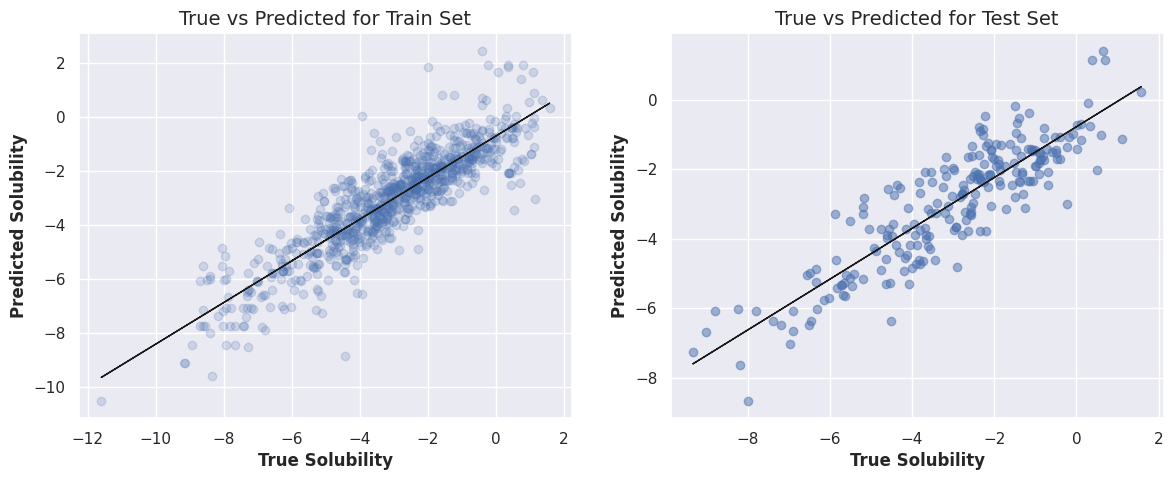

In [32]:
plot_train_test_comparison(y_train, y_test, y_pred_train, y_pred_test)

#### Linear Regression: Exlainability

In [33]:
# explain the model's predictions using SHAP
explainer_train = shap.explainers.Linear(model, X_train)
shap_values_train = explainer_train(X_train)
shap_values_train.shape

(915, 4)

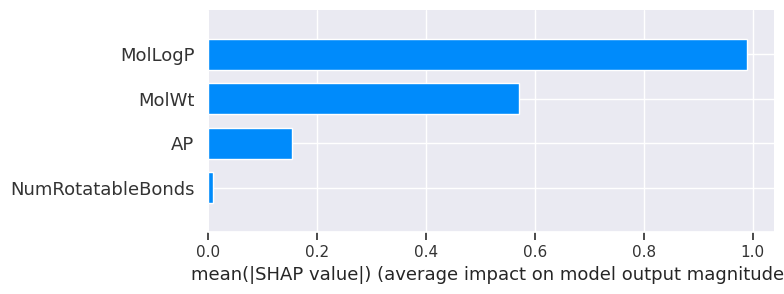

In [34]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar", feature_names=features)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


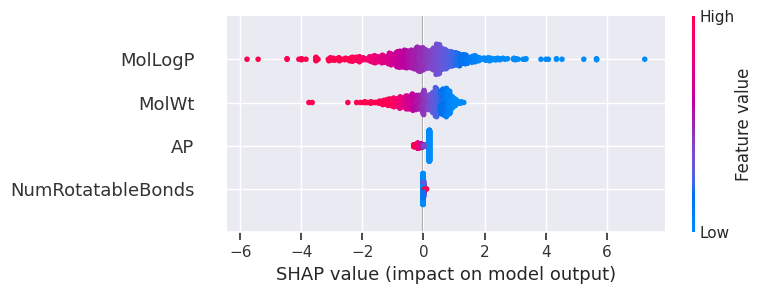

In [35]:
shap.summary_plot(shap_values_train, X_train, feature_names=features)

In [36]:
explainer_test = shap.explainers.Linear(model, X_test)
shap_values_test = explainer_test(X_test)
shap_values_test.shape

(229, 4)

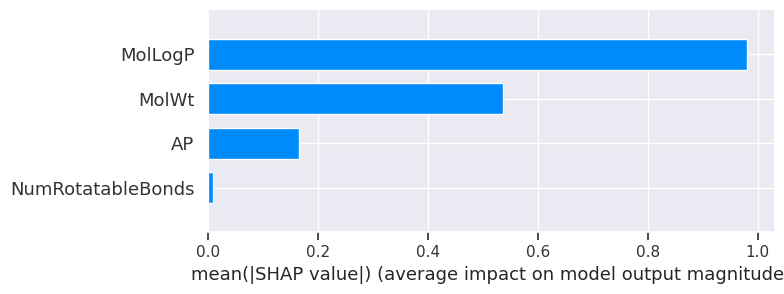

In [37]:
shap.summary_plot(shap_values_test, X_test, plot_type="bar", feature_names=features)

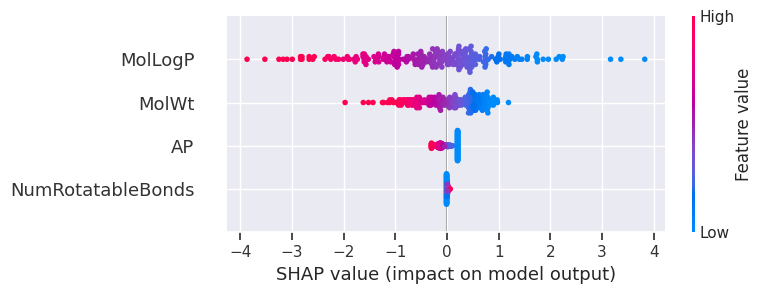

In [38]:
shap.summary_plot(shap_values_test, X_test, feature_names=features)

### 4.3 Random Forest

In [39]:
rf_reg = RandomForestRegressor(max_depth=10, random_state=0)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [40]:
feature_importances = []
for feature, importance in zip(features, rf_reg.feature_importances_):
    feature_importances.append((feature, importance))

feature_importances.sort(key=lambda item: item[1], reverse=True)

In [41]:
print("feature : importance")
print("-------------------")
for feature, importance in feature_importances:
    print(feature, ":", np.round(importance, 4))

feature : importance
-------------------
MolLogP : 0.835
MolWt : 0.1262
AP : 0.0202
NumRotatableBonds : 0.0186


In [42]:
rf_reg.score(X_train, y_train)

0.9693734167490539

In [43]:
rf_reg.score(X_test, y_test)

0.8854430690575864

In [44]:
rf_y_pred_train = rf_reg.predict(X_train)
rf_y_pred_train.shape

(915,)

In [45]:
rf_y_pred_test = rf_reg.predict(X_test)
rf_y_pred_test.shape

(229,)

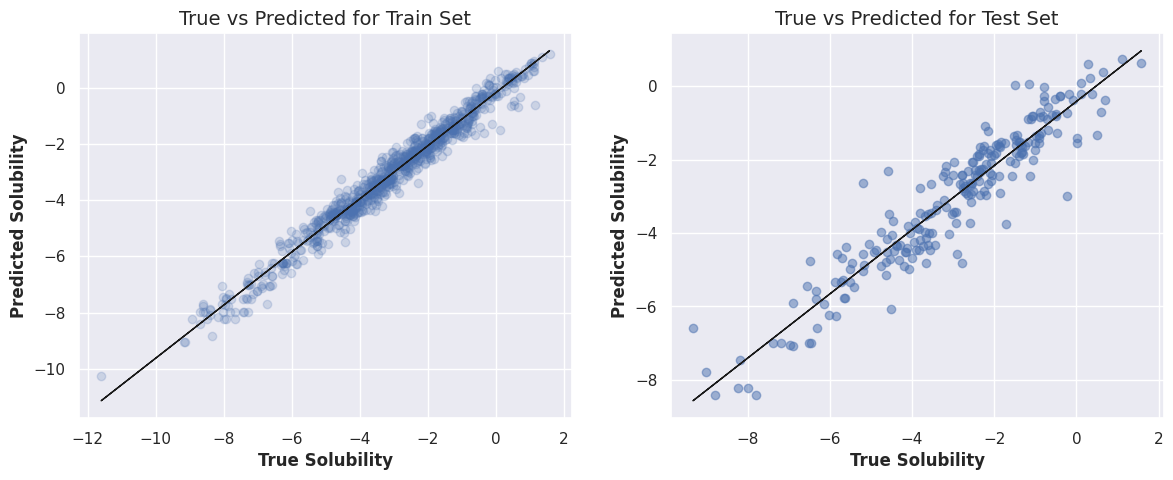

In [46]:
plot_train_test_comparison(y_train, y_test, rf_y_pred_train, rf_y_pred_test)